# **1. Install Necessary Package**

In [2]:
# ============================================================================
# Force reinstall datasets cleanly (Something wrong on my end, need
# to unstall the first 'dataset' package and use the second. Not
# sure if others need or not.)
# ============================================================================
!pip uninstall -y datasets

Found existing installation: datasets 3.5.0
Uninstalling datasets-3.5.0:
  Successfully uninstalled datasets-3.5.0


In [3]:
!pip install datasets

  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
Using cached datasets-3.5.0-py3-none-any.whl (491 kB)


In [4]:
!pip install transformers==4.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 66.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.17.0 which is incompatible.


# **2. Load and Preprocess Dataset**

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [6]:
# Loading Package
import os
import re
import matplotlib.pyplot as plt
import csv
import uuid
import nltk
import json
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import EarlyStoppingCallback
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from transformers import TrainingArguments, Trainer
from torch.utils.data import Dataset as TorchDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset, load_dataset, get_dataset_config_names
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

In [ ]:
# Data Saving. Only run once (Delete previous file in Google Doc if you need to rerun.)
path_to_file = '/content/gdrive/My Drive'
# Create the target directory if it doesn't exist
os.makedirs("/content/gdrive/My Drive/filtered_reviews", exist_ok=True)
TARGET_PER_CLASS = 5000  # max number of reviews per sentiment
MAX_TOTAL = TARGET_PER_CLASS * 3

def get_sentiment_class(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating == 3:
        return "neutral"
    elif rating in [4, 5]:
        return "positive"
    return None

# Load all raw_review configs
all_configs = get_dataset_config_names("McAuley-Lab/Amazon-Reviews-2023")
raw_review_configs = [cfg for cfg in all_configs if cfg.startswith("raw_review")]

for config_name in raw_review_configs:
    print(f"🔄 Processing {config_name}...")

    dataset = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        config_name,
        split="full",
        streaming=True,
        trust_remote_code=True
    )

    output_path = f"{path_to_file}/filtered_reviews/{config_name}.csv"
    with open(output_path, mode="w", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            "asin", "title", "text", "rating", "sentiment",
            "user_id", "timestamp", "verified_purchase", "helpful_vote"
        ])

        class_counts = defaultdict(int)

        for item in dataset:
            try:
                rating = int(round(float(item.get("rating", -1))))
            except:
                continue

            sentiment = get_sentiment_class(rating)
            if sentiment is None or class_counts[sentiment] >= TARGET_PER_CLASS:
                continue

            asin = item.get("asin", item.get("parent_asin", ""))
            title = item.get("title", "") or item.get("summary", "")
            text = item.get("text", "") or item.get("reviewText", "")
            user_id = item.get("user_id", "")
            timestamp = item.get("timestamp", "")
            verified = item.get("verified_purchase", "")
            helpful = item.get("helpful_vote", 0)

            writer.writerow([
                asin, title, text, rating, sentiment,
                user_id, timestamp, verified, helpful
            ])

            class_counts[sentiment] += 1

            if sum(class_counts.values()) >= MAX_TOTAL:
                break

        print(f"✅ Saved {sum(class_counts.values())} reviews from {config_name}: {dict(class_counts)}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

The repository for McAuley-Lab/Amazon-Reviews-2023 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/McAuley-Lab/Amazon-Reviews-2023.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
🔄 Processing raw_review_All_Beauty...
✅ Saved 15000 reviews from raw_review_All_Beauty: {'positive': 5000, 'negative': 5000, 'neutral': 5000}
🔄 Processing raw_review_Toys_and_Games...
✅ Saved 15000 reviews from raw_review_Toys_and_Games: {'positive': 5000, 'neutral': 5000, 'negative': 5000}
🔄 Processing raw_review_Cell_Phones_and_Accessories...
✅ Saved 15000 reviews from raw_review_Cell_Phones_and_Accessories: {'positive': 5000, 'neutral': 5000, 'negative': 5000}
🔄 Processing raw_review_Industrial_and_Scientific...
✅ Saved 15000 reviews from raw_review_Industrial_and_Scientific: {'positive': 5000, 'negative': 5000, 'neutral': 5000}
🔄 Pro

In [9]:
# Data Cleaning & Balanced Only Run Once (Delete previous file in Google Doc if you need to rerun.)
# Path to your group CSVs
input_dir = "/content/gdrive/My Drive/filtered_reviews"
output_path = "/content/gdrive/My Drive/filtered_reviews/final_balanced_reviews.csv"

# Storage for all sampled subsets
all_data = []

# Loop through all group CSV files
for file in os.listdir(input_dir):
    if not file.endswith(".csv") or file == "combined_reviews.csv":
        continue

    file_path = os.path.join(input_dir, file)
    print(f"📥 Loading {file}...")

    # Read the group file
    df = pd.read_csv(file_path)

    # Skip if required columns are missing
    if not {'text', 'sentiment', 'title'}.issubset(df.columns):
        print(f"⚠️ Skipping {file} — missing columns.")
        continue

    # Drop missing
    df = df[['title', 'text', 'sentiment']].dropna()

    # Sample 1000 per class
    try:
        df_sampled = df.groupby('sentiment', group_keys=False).apply(
            lambda x: x.sample(n=1000, random_state=42)
        ).reset_index(drop=True)

        all_data.append(df_sampled)
    except:
        print(f"⚠️ Not enough data in {file}, skipping...")

# Combine all sampled data
final_df = pd.concat(all_data, ignore_index=True)

# Create model input by combining title and text
final_df['input'] = final_df['title'].str.strip() + ' ' + final_df['text'].str.strip()

# Encode sentiment to numerical label
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
final_df['label'] = df['sentiment'].map(label_map)

# Add unique review_id column
final_df['review_id'] = [str(uuid.uuid4()) for _ in range(len(final_df))]

# Move review_id to first column
cols = ['review_id'] + [col for col in final_df.columns if col != 'review_id']
final_df = final_df[cols]

# Save to CSV (including input, title, text, sentiment, label)
final_df.to_csv(output_path, index=False, encoding="utf-8")

print(f"Final dataset saved: {output_path}")
print(final_df['sentiment'].value_counts())


📥 Loading raw_review_All_Beauty.csv...
📥 Loading raw_review_Toys_and_Games.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavio

📥 Loading raw_review_Cell_Phones_and_Accessories.csv...
📥 Loading raw_review_Industrial_and_Scientific.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Gift_Cards.csv...
📥 Loading raw_review_Musical_Instruments.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Electronics.csv...
📥 Loading raw_review_Handmade_Products.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Arts_Crafts_and_Sewing.csv...
📥 Loading raw_review_Baby_Products.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Health_and_Household.csv...
📥 Loading raw_review_Office_Products.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Digital_Music.csv...
📥 Loading raw_review_Grocery_and_Gourmet_Food.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Sports_and_Outdoors.csv...
📥 Loading raw_review_Home_and_Kitchen.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Subscription_Boxes.csv...
📥 Loading raw_review_Tools_and_Home_Improvement.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Pet_Supplies.csv...
📥 Loading raw_review_Video_Games.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Kindle_Store.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Clothing_Shoes_and_Jewelry.csv...
📥 Loading raw_review_Patio_Lawn_and_Garden.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Unknown.csv...
📥 Loading raw_review_Books.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Automotive.csv...
📥 Loading raw_review_CDs_and_Vinyl.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Beauty_and_Personal_Care.csv...
📥 Loading raw_review_Amazon_Fashion.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Magazine_Subscriptions.csv...
📥 Loading raw_review_Software.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Health_and_Personal_Care.csv...
📥 Loading raw_review_Appliances.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(
<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


📥 Loading raw_review_Movies_and_TV.csv...
📥 Loading final_balanced_reviews.csv...


<ipython-input-9-5095c34d562c>:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('sentiment', group_keys=False).apply(


Final dataset saved: /content/gdrive/My Drive/filtered_reviews/final_balanced_reviews1.csv
sentiment
negative    35000
neutral     35000
positive    35000
Name: count, dtype: int64


In [3]:
df = pd.read_csv("/content/gdrive/My Drive/filtered_reviews/final_balanced_reviews.csv")
print("Total samples:", len(df))
print("Class distribution:\n", df['sentiment'].value_counts())
print(df.head(10))


Total samples: 102000
Class distribution:
 sentiment
negative    34000
neutral     34000
positive    34000
Name: count, dtype: int64
                              review_id  \
0  fe70f3d2-743b-41d9-8c11-a1478683920b   
1  0c12eeda-f14b-4cbb-be34-9fb53e65c482   
2  c8ad64e5-1df4-4130-963f-87e7e1306614   
3  d3baee99-5cec-4402-8d8e-f7b1f22509ab   
4  863b859c-0d02-4355-b2e2-fdac0f9e0b56   
5  c016298a-f893-4bda-9119-499cf1037790   
6  237149f5-7568-4a5a-9779-656c92d4e221   
7  1d2c82a1-1104-465a-bcbe-b1a060d0266c   
8  7980f9aa-9635-4a7e-8084-c6d87b75087c   
9  3b876adc-554e-4beb-a193-a165f0629e78   

                                           title  \
0                 Cleaning chemical smell yuck!!   
1                           Major disappointment   
2                              Like it but broke   
3               Something is off with the smell.   
4                        All that pain for what?   
5                  Way too yellow - not as moist   
6                        Will

# **3. EDA**

In [25]:
# ==========================================
# 1. Load Sample of True Raw Data (~100K)
# ==========================================
# Settings
MAX_RECORDS = 100_000

def get_sentiment_class(rating):
    try:
        rating = int(round(float(rating)))
        if rating in [1, 2]:
            return "negative"
        elif rating == 3:
            return "neutral"
        elif rating in [4, 5]:
            return "positive"
    except:
        return None

# Get available configs (like raw_review_Books, raw_review_Toys, etc.)
all_configs = get_dataset_config_names("McAuley-Lab/Amazon-Reviews-2023")
raw_review_configs = [cfg for cfg in all_configs if cfg.startswith("raw_review")]

# Storage for all records
records = []
total_count = 0

# Loop over datasets
for config_name in raw_review_configs:
    print(f"🔄 Streaming from {config_name}...")

    dataset = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        config_name,
        split="full",
        streaming=True,
        trust_remote_code=True
    )

    for item in tqdm(dataset, desc=f"Collecting from {config_name}"):
        rating = item.get("rating", None)
        sentiment = get_sentiment_class(rating)
        if sentiment is None:
            continue

        records.append({
            "asin": item.get("asin", item.get("parent_asin", "")),
            "title": item.get("title", "") or item.get("summary", ""),
            "text": item.get("text", "") or item.get("reviewText", ""),
            "rating": rating,
            "sentiment": sentiment,
            "user_id": item.get("user_id", ""),
            "timestamp": item.get("timestamp", ""),
            "verified_purchase": item.get("verified_purchase", ""),
            "helpful_vote": item.get("helpful_vote", 0)
        })

        total_count += 1
        if total_count >= MAX_RECORDS:
            break
    if total_count >= MAX_RECORDS:
        break

# Convert to DataFrame
raw_df = pd.DataFrame(records)
print("✅ Loaded shape:", raw_df.shape)
print(f"\n✅ Loaded {len(raw_df)} samples into memory.")


🔄 Streaming from raw_review_All_Beauty...



✅ Loaded 100000 samples into memory.


In [26]:
raw_df.head()

,asin,title,text,rating,sentiment,user_id,timestamp,verified_purchase,helpful_vote
0,B00YQ6X8EO,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,5.0,positive,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,True,0
1,B081TJ8YS3,Works great but smells a little weird.,"This product does what I need it to do, I just...",4.0,positive,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,True,1
2,B07PNNCSP9,Yes!,"Smells good, feels great!",5.0,positive,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,True,2
3,B09JS339BZ,Synthetic feeling,Felt synthetic,1.0,negative,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,True,0
4,B08BZ63GMJ,A+,Love it,5.0,positive,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,True,0


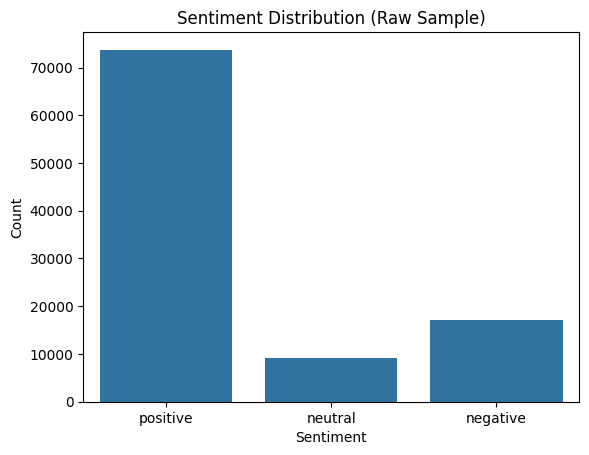

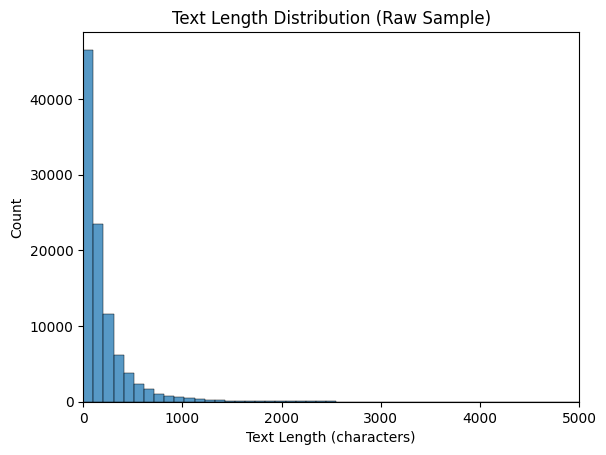

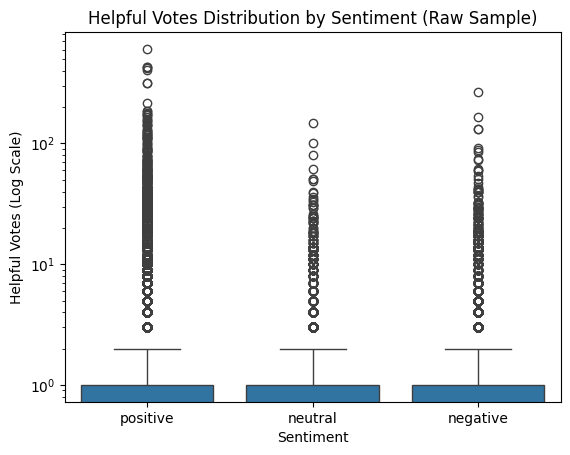

In [37]:
# =======================
# Sentiment Distribution
# =======================
sns.countplot(data=raw_df, x="sentiment", order=["positive", "neutral", "negative"])
plt.title("Sentiment Distribution (Raw Sample)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# =======================
# Text Length Distribution
# =======================
raw_df["text_length"] = raw_df["text"].astype(str).apply(len)

sns.histplot(data=raw_df, x="text_length", bins=100)
plt.xlim(0, 5000)  # Limit to ignore extreme outliers
plt.title("Text Length Distribution (Raw Sample)")
plt.xlabel("Text Length (characters)")
plt.ylabel("Count")
plt.show()

# =======================
# Helpful Votes by Sentiment
# =======================
sns.boxplot(data=raw_df, x="sentiment", y="helpful_vote", order=["positive", "neutral", "negative"])
plt.yscale("log")  # Log scale due to skew
plt.title("Helpful Votes Distribution by Sentiment (Raw Sample)")
plt.xlabel("Sentiment")
plt.ylabel("Helpful Votes (Log Scale)")
plt.show()

In [32]:
# =======================================
# 2. EDA on Cleaned & Balanced Data
#=========================================
balanced_df = pd.read_csv("/content/gdrive/My Drive/filtered_reviews/final_balanced_reviews.csv")
print("Balanced dataset shape:", balanced_df.shape)
print(balanced_df['sentiment'].value_counts())


Balanced dataset shape: (102000, 6)
sentiment
negative    34000
neutral     34000
positive    34000
Name: count, dtype: int64


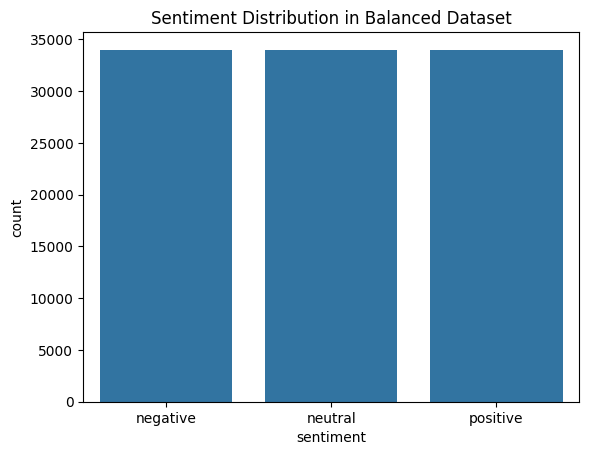

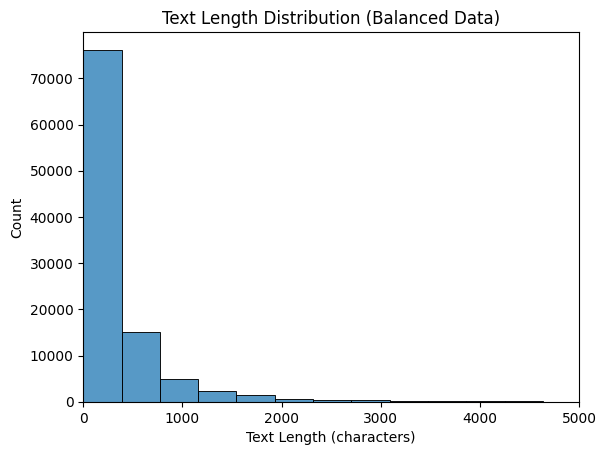

In [33]:
# Sentiment count
sns.countplot(data=balanced_df, x='sentiment')
plt.title("Sentiment Distribution in Balanced Dataset")
plt.show()

# Text length distribution
balanced_df['text_length'] = balanced_df['text'].astype(str).apply(len)
sns.histplot(balanced_df['text_length'], bins=50)
plt.title("Text Length Distribution (Balanced Data)")
plt.xlim(0, 5000)
plt.xlabel("Text Length (characters)")
plt.ylabel("Count")
plt.show()


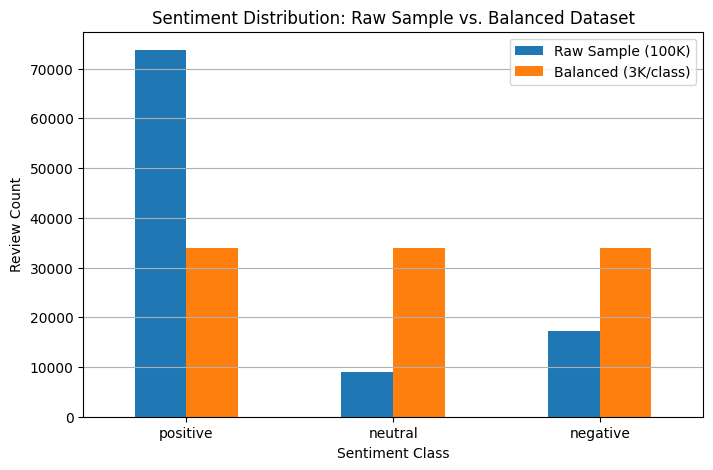

In [36]:
# =======================================
# 3. Comparision
#=========================================
# Compare sentiment distributions side by side
# Ensure both DataFrames use consistent casing
raw_df['sentiment'] = raw_df['sentiment'].str.lower()
balanced_df['sentiment'] = balanced_df['sentiment'].str.lower()

# Count sentiment classes in both datasets
raw_counts = raw_df['sentiment'].value_counts().reindex(["positive", "neutral", "negative"])
balanced_counts = balanced_df['sentiment'].value_counts().reindex(["positive", "neutral", "negative"])

# Build comparison DataFrame
comparison_df = pd.DataFrame({
    'Raw Sample (100K)': raw_counts,
    'Balanced (3K/class)': balanced_counts
}).reset_index().rename(columns={'index': 'Sentiment'})

# Plot side-by-side bar chart
comparison_df.set_index('sentiment').plot(kind='bar', figsize=(8, 5))
plt.title("Sentiment Distribution: Raw Sample vs. Balanced Dataset")
plt.ylabel("Review Count")
plt.xlabel("Sentiment Class")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


# **4. Tranformer (Roberta) Model**

In [14]:

# Load the full data including 'title'
df = pd.read_csv('/content/gdrive/My Drive/filtered_reviews/final_balanced_reviews.csv')

# Convert to Hugging Face Dataset (including review_id)
hf_dataset = Dataset.from_pandas(df[['review_id', 'input', 'label']])

# Split into 80% train, 10% val, 10% test
split_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)
val_test = split_dataset['test'].train_test_split(test_size=0.5, seed=42)

# Final dataset dict
dataset = {
    'train': split_dataset['train'],
    'val': val_test['train'],
    'test': val_test['test']
}

print(f"Dataset split complete: Train={len(dataset['train'])}, Val={len(dataset['val'])}, Test={len(dataset['test'])}")


Dataset split complete: Train=81600, Val=10200, Test=10200


In [15]:
# Tokenize reviews
# checkpoint = "roberta-base"
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["input"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Tokenize all splits
tokenized_datasets = {
    split: dataset[split].map(tokenize_function, batched=True)
    for split in ['train', 'val', 'test']
}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/81600 [00:00<?, ? examples/s]

Map:   0%|          | 0/10200 [00:00<?, ? examples/s]

Map:   0%|          | 0/10200 [00:00<?, ? examples/s]

In [16]:
# Confirm GPU available and print GPU info
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU available: {num_gpus} GPU(s) detected.")
    print(f"🖥️ GPU Name: {gpu_name}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not available, using CPU.")
    device = torch.device("cpu")

# Load model to the selected device
checkpoint = "roberta-base"
# Load model with 3 output labels
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3).to(device)



✅ GPU available: 1 GPU(s) detected.
🖥️ GPU Name: NVIDIA A100-SXM4-40GB


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [17]:
# Function for Evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [18]:
training_args = TrainingArguments(
    output_dir="/content/gdrive/My Drive/filtered_reviews/review_classifier_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.05,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"  # disable wandb reporting
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


In [ ]:
trainer.train()


The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: input, review_id. If input, review_id are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 81600
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25500


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.457100,0.488866,0.806078,0.810782,0.806078,0.802213
2,0.412200,0.443404,0.819020,0.821378,0.819020,0.819563
3,0.360200,0.468756,0.816373,0.817135,0.816373,0.816288
4,0.302400,0.526368,0.814510,0.814664,0.814510,0.814482


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: input, review_id. If input, review_id are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10200
  Batch size = 16
Saving model checkpoint to /content/gdrive/My Drive/filtered_reviews/review_classifier_output/checkpoint-5100
Configuration saved in /content/gdrive/My Drive/filtered_reviews/review_classifier_output/checkpoint-5100/config.json
Model weights saved in /content/gdrive/My Drive/filtered_reviews/review_classifier_output/checkpoint-5100/pytorch_model.bin
tokenizer config file saved in /content/gdrive/My Drive/filtered_reviews/review_classifier_output/checkpoint-5100/tokenizer_config.json
Special tokens file saved in /content/gdrive/My Drive/filtered_reviews/review_classifier_output/checkpoint-5100/special_tokens_map.json
The following c

TrainOutput(global_step=20400, training_loss=0.3841777307846967, metrics={'train_runtime': 7962.424, 'train_samples_per_second': 51.241, 'train_steps_per_second': 3.203, 'total_flos': 8.722315043050291e+16, 'train_loss': 0.3841777307846967, 'epoch': 4.0})

In [ ]:
test_results = trainer.evaluate(tokenized_datasets['test'])
print("Final Test Set Evaluation:")
print(test_results)


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: input, review_id. If input, review_id are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10200
  Batch size = 16


Final Test Set Evaluation:
{'eval_loss': 0.44504308700561523, 'eval_accuracy': 0.8152941176470588, 'eval_precision': 0.8176387756933874, 'eval_recall': 0.8152941176470588, 'eval_f1': 0.8158069466228908, 'eval_runtime': 79.5256, 'eval_samples_per_second': 128.261, 'eval_steps_per_second': 8.023, 'epoch': 4.0}


In [ ]:
# Check if 'test' balanced
print(Counter(dataset['test']['label']))

Counter({2: 3456, 0: 3411, 1: 3333})


In [ ]:
# Check the output ratio
predictions = trainer.predict(tokenized_datasets['test'])
print("Prediction label counts:", np.bincount(predictions.predictions.argmax(axis=1)))

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: input, review_id. If input, review_id are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10200
  Batch size = 16


Prediction label counts: [3158 3560 3482]


In [ ]:
# Check if input_ids look normal
tokenized_datasets['test'][0]

{'review_id': 'cb35f6d1-a297-4cf6-99bc-19d1c3e05116',
 'input': 'Same Old Pseudo Ghost Documentary *Spoilers*<br /><br />I do believe that the family’s experiences in the home and that the police reports were true.<br />But the whole investigation was just outright ridiculous. Every time the host sits on camera to start talking, something just “happens” to move or make noise. The camera shots of things moving in the night or coming on? Come ON.<br />First the “radio” that just happened to come on outside of the picture frame or at the edge of it? Yeah right. Most speakers now have remotes or are connected to phones.<br />And, of course, it was so dark and so out of frame that anyone could’ve literally just pressed the power button. Oh, and of course heavy metal music just happened to come on....<br />The “door that slowly opened“ did not have a full and direct view so anyone could’ve been in there or used string to pull the top or bottom of the door.<br />The “faucet” would have been e

In [19]:
# Run prediction on the test set
predictions_output = trainer.predict(tokenized_datasets['test'])

# Get predicted labels
predicted_labels = predictions_output.predictions.argmax(axis=1)

# Get true labels and review_ids
true_labels = tokenized_datasets['test']['label']
review_ids = tokenized_datasets['test']['review_id']

# Build output records
output_records = []
for i in range(len(predicted_labels)):
    output_records.append({
        "review_id": review_ids[i],
        "true_label": int(true_labels[i]),
        "transformer_pred": int(predicted_labels[i])
    })

# Save to JSON
output_json_path = "/content/gdrive/My Drive/filtered_reviews/transformer_predictions.json"
with open(output_json_path, "w", encoding="utf-8") as f:
    for record in output_records:
        json.dump(record, f)
        f.write("\n")

print(f"Transformer predictions saved to: {output_json_path}")


The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: input, review_id. If input, review_id are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10200
  Batch size = 16


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Transformer predictions saved to: /content/gdrive/My Drive/filtered_reviews/transformer_predictions.json


# **5. Data processing for Logistic Regression**

In [ ]:
# Save as CSV, if need
df_output = pd.DataFrame(output_records)
output_csv_path = "/content/gdrive/My Drive/filtered_reviews/transformer_predictions.csv"
df_output.to_csv(output_csv_path, index=False)
print(f"Transformer predictions also saved to: {output_csv_path}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


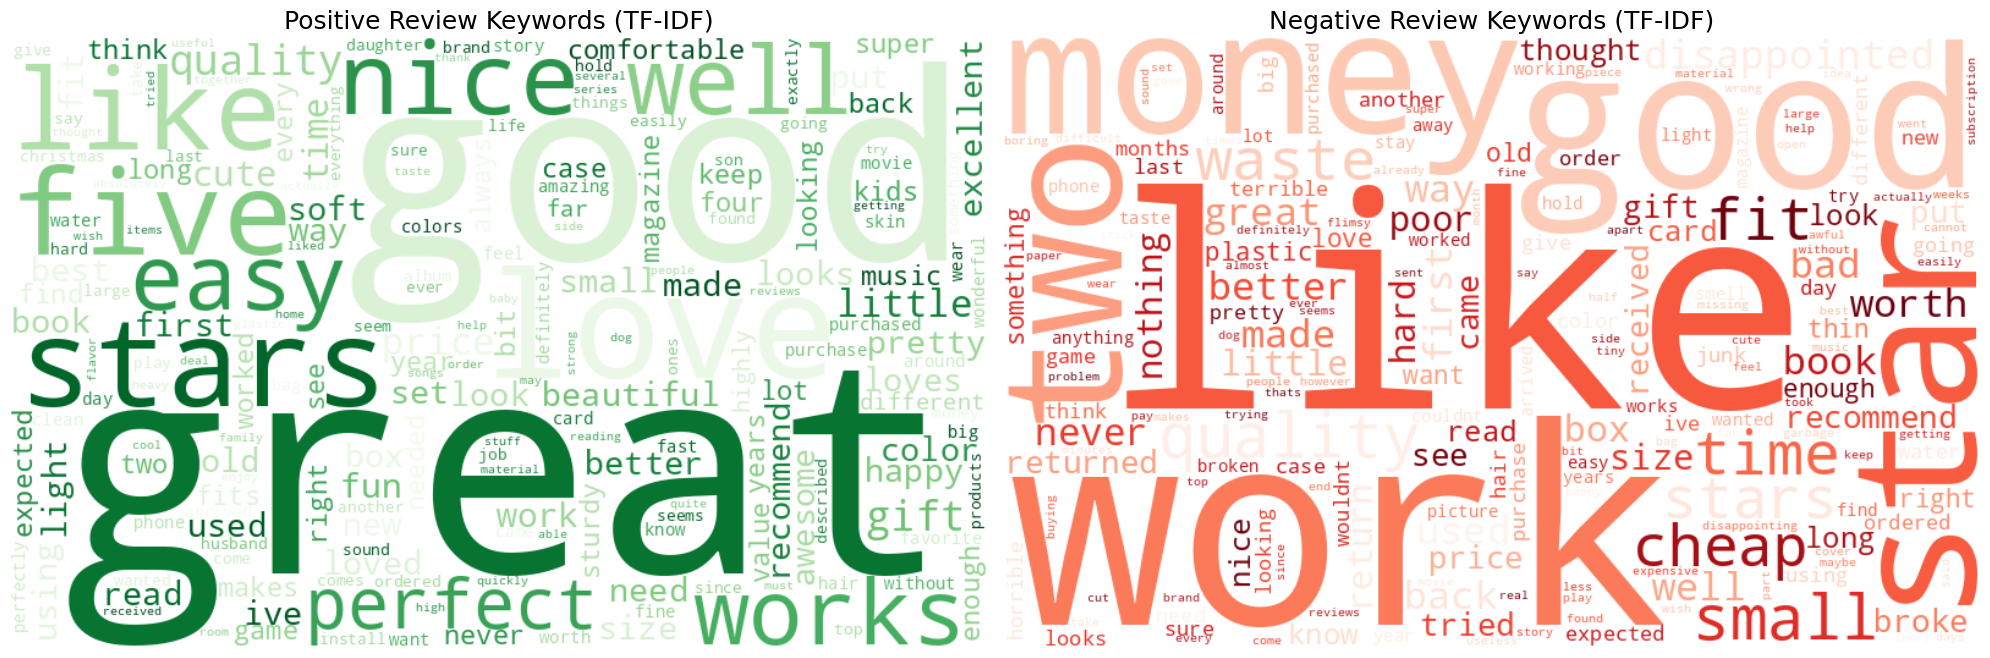


🔵 Top 10 Positive Review Keywords:
great           0.0604
good            0.0450
love            0.0391
stars           0.0336
five            0.0302
like            0.0279
nice            0.0276
well            0.0251
easy            0.0233
works           0.0231

🔴 Top 10 Negative Review Keywords:
like            0.0307
work            0.0264
good            0.0223
money           0.0204
star            0.0203
two             0.0186
quality         0.0168
small           0.0165
time            0.0160
waste           0.0155


In [7]:
# === Stopword Removal + WordCloud Visualization (for insight) ===

# Download NLTK stopwords
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))

# Combine with domain-specific stopwords
custom_stopwords = nltk_stopwords | {
    "product", "use", "one", "thing", "item", "get", "got", "would", "really", "could",
    "also", "still", "even", "though", "make", "much", "many", "buy", "bought", "review",
    "amazon", "dont", "didnt", "doesnt", "wasnt", "isnt", "arent", "wont", "cant", "im"
}

# Load shared dataset
wc_df = pd.read_csv('/content/gdrive/My Drive/filtered_reviews/final_balanced_reviews.csv')
wc_df['title'] = wc_df['title'].fillna('')
wc_df['text'] = wc_df['text'].fillna('')
wc_df['text_combined'] = wc_df['title'].str.strip() + ' ' + wc_df['text'].str.strip()

# Clean text function
def clean_for_wordcloud(text):
    text = BeautifulSoup(str(text), "html.parser").get_text()
    text = re.sub(r"[^a-zA-Z\s]", "", text).lower()
    return " ".join([w for w in text.split() if w not in custom_stopwords and len(w) > 2])

wc_df['text_cleaned'] = wc_df['text_combined'].apply(clean_for_wordcloud)

# Split
positive_texts = wc_df[wc_df['sentiment'].str.lower() == 'positive']['text_cleaned'].tolist()
negative_texts = wc_df[wc_df['sentiment'].str.lower() == 'negative']['text_cleaned'].tolist()

# TF-IDF function
def compute_tfidf_freqs(texts):
    tfidf = TfidfVectorizer(max_features=1000)
    mat = tfidf.fit_transform(texts)
    return dict(zip(tfidf.get_feature_names_out(), mat.mean(axis=0).A1))

pos_freqs = compute_tfidf_freqs(positive_texts)
neg_freqs = compute_tfidf_freqs(negative_texts)

# Plot word clouds
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
wc_pos = WordCloud(width=800, height=500, background_color='white', colormap='Greens').generate_from_frequencies(pos_freqs)
wc_neg = WordCloud(width=800, height=500, background_color='white', colormap='Reds').generate_from_frequencies(neg_freqs)

axs[0].imshow(wc_pos, interpolation='bilinear')
axs[0].set_title("Positive Review Keywords (TF-IDF)", fontsize=18)
axs[0].axis('off')

axs[1].imshow(wc_neg, interpolation='bilinear')
axs[1].set_title("Negative Review Keywords (TF-IDF)", fontsize=18)
axs[1].axis('off')

plt.tight_layout()
plt.show()

# Print top keywords
print("\n🔵 Top 10 Positive Review Keywords:")
for w, s in sorted(pos_freqs.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{w:<15} {s:.4f}")

print("\n🔴 Top 10 Negative Review Keywords:")
for w, s in sorted(neg_freqs.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{w:<15} {s:.4f}")


In [8]:
wc_df.head()

,review_id,title,text,sentiment,input,label,text_combined,text_cleaned
0,fe70f3d2-743b-41d9-8c11-a1478683920b,Cleaning chemical smell yuck!!,Awful!! The smelling is gagging! Smells like ...,negative,Cleaning chemical smell yuck!! Awful!! The sm...,0,Cleaning chemical smell yuck!! Awful!! The sm...,cleaning chemical smell yuck awful smelling ga...
1,0c12eeda-f14b-4cbb-be34-9fb53e65c482,Major disappointment,I have tried just about every volumizing powde...,negative,Major disappointment I have tried just about e...,0,Major disappointment I have tried just about e...,major disappointment tried every volumizing po...
2,c8ad64e5-1df4-4130-963f-87e7e1306614,Like it but broke,I reallllllly like this ring. I had it for 5 d...,negative,Like it but broke I reallllllly like this ring...,0,Like it but broke I reallllllly like this ring...,like broke reallllllly like ring days wearing ...
3,d3baee99-5cec-4402-8d8e-f7b1f22509ab,Something is off with the smell.,"I am not sure what’s up with the smell, but it...",negative,Something is off with the smell. I am not sure...,0,Something is off with the smell. I am not sure...,something smell sure whats smell describe say ...
4,863b859c-0d02-4355-b2e2-fdac0f9e0b56,All that pain for what?,"I have coarse stubble since I'm Italian, and I...",negative,All that pain for what? I have coarse stubble ...,0,All that pain for what? I have coarse stubble ...,pain coarse stubble since italian hoping help ...


# **6. Logistic Regression**

In [20]:
# =========================================
# Logistic Regression with TF-IDF
# =========================================


# Load shared dataset
logi_df = pd.read_csv('/content/gdrive/My Drive/filtered_reviews/final_balanced_reviews.csv')
logi_df['title'] = logi_df['title'].fillna('')
logi_df['text'] = logi_df['text'].fillna('')
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
logi_df['label'] = logi_df['sentiment'].map(label_map)

# Clean text
def clean_text_logi(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    return re.sub(r"[^a-zA-Z\s]", "", text).lower()

logi_df['clean_title'] = logi_df['title'].apply(clean_text_logi)
logi_df['clean_text'] = logi_df['text'].apply(clean_text_logi)

# 80:10:10 Split (Train/Val/Test)
from sklearn.model_selection import train_test_split
X_title = logi_df['clean_title'].tolist()
X_text = logi_df['clean_text'].tolist()
y_logi = logi_df['label'].tolist()
id_logi = logi_df['review_id'].tolist()

X_temp_t, X_test_t, X_temp_x, X_test_x, y_temp, y_test_logi, _, id_test_logi = train_test_split(
    X_title, X_text, y_logi, id_logi, test_size=0.1, random_state=42, stratify=y_logi)
X_train_t, X_val_t, X_train_x, X_val_x, y_train_logi, y_val_logi = train_test_split(
    X_temp_t, X_temp_x, y_temp, test_size=0.1111, random_state=42, stratify=y_temp)

# TF-IDF Vectorization
title_vec = TfidfVectorizer(max_features=3000)
text_vec = TfidfVectorizer(max_features=5000)

X_train_logi = np.hstack([
    title_vec.fit_transform(tqdm(X_train_t, desc="TF-IDF title train")).toarray(),
    text_vec.fit_transform(tqdm(X_train_x, desc="TF-IDF text train")).toarray()
])

X_val_logi = np.hstack([
    title_vec.transform(tqdm(X_val_t, desc="TF-IDF title val")).toarray(),
    text_vec.transform(tqdm(X_val_x, desc="TF-IDF text val")).toarray()
])

X_test_logi = np.hstack([
    title_vec.transform(tqdm(X_test_t, desc="TF-IDF title test")).toarray(),
    text_vec.transform(tqdm(X_test_x, desc="TF-IDF text test")).toarray()
])

# Train & Predict
clf_logi = LogisticRegression(max_iter=1000)
clf_logi.fit(X_train_logi, y_train_logi)
y_pred_logi = clf_logi.predict(X_test_logi)

# Evaluate on Test Set
print("\n📊 Logistic Regression Evaluation:")
print(f"✅ Accuracy: {accuracy_score(y_test_logi, y_pred_logi):.4f}")
print(f"🎯 Macro F1 Score: {f1_score(y_test_logi, y_pred_logi, average='macro'):.4f}")
print(f"📉 Negative Recall: {recall_score(y_test_logi, y_pred_logi, average=None)[0]:.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_test_logi, y_pred_logi, target_names=['negative', 'neutral', 'positive']))

# Export
pd.DataFrame({
    'review_id': id_test_logi,
    'true_label': y_test_logi,
    'logistic_pred': y_pred_logi
}).to_json("/content/gdrive/My Drive/filtered_reviews/logistic_predictions.json", orient="records", lines=True)

print("\n Logistic Regression predictions saved.")


<ipython-input-20-7b97180f2bd7>:15: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(text, "html.parser").get_text()
<ipython-input-20-7b97180f2bd7>:15: MarkupResemblesLocatorWarning: The input passed


📊 Logistic Regression Evaluation:
✅ Accuracy: 0.7432
🎯 Macro F1 Score: 0.7420
📉 Negative Recall: 0.7576

🔍 Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.76      0.74      3400
     neutral       0.66      0.62      0.64      3400
    positive       0.83      0.85      0.84      3400

    accuracy                           0.74     10200
   macro avg       0.74      0.74      0.74     10200
weighted avg       0.74      0.74      0.74     10200


 Logistic Regression predictions saved.


# **7. Bi-LSTM**

In [28]:
# =========================================
# Bi-LSTM with RoBERTa Embeddings and Early Stopping (80:10:10 Split)
# =========================================

# Load dataset
lstm_df = pd.read_csv('/content/gdrive/My Drive/filtered_reviews/final_balanced_reviews.csv')
lstm_df['title'] = lstm_df['title'].fillna('')
lstm_df['text'] = lstm_df['text'].fillna('')
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
lstm_df['label'] = lstm_df['sentiment'].map(label_map)

# Define GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split
X_title_lstm = lstm_df['title'].tolist()
X_text_lstm = lstm_df['text'].tolist()
y_lstm = lstm_df['label'].tolist()
id_lstm = lstm_df['review_id'].tolist()

X_temp_t, X_test_t, X_temp_x, X_test_x, y_temp_lstm, y_test_lstm, _, id_test_lstm = train_test_split(
    X_title_lstm, X_text_lstm, y_lstm, id_lstm, test_size=0.1, random_state=42, stratify=y_lstm)
X_train_t, X_val_t, X_train_x, X_val_x, y_train_lstm, y_val_lstm = train_test_split(
    X_temp_t, X_temp_x, y_temp_lstm, test_size=0.1111, random_state=42, stratify=y_temp_lstm)

# Dataset
tokenizer_lstm = AutoTokenizer.from_pretrained("roberta-base")
tokenizer_lstm.pad_token = tokenizer_lstm.eos_token
max_len = 64
class RobertaDataset(TorchDataset):
    def __init__(self, titles, texts, labels):
        self.pairs = [f"{a} {b}" for a, b in zip(titles, texts)]
        self.labels = labels
    def __getitem__(self, idx):
        enc = tokenizer_lstm(self.pairs[idx], truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
        return {
            'input_ids': enc['input_ids'].squeeze(),
            'attention_mask': enc['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx])
        }
    def __len__(self):
        return len(self.labels)

train_dl = DataLoader(RobertaDataset(X_train_t, X_train_x, y_train_lstm), batch_size=16, shuffle=True)
val_dl = DataLoader(RobertaDataset(X_val_t, X_val_x, y_val_lstm), batch_size=16)
test_dl = DataLoader(RobertaDataset(X_test_t, X_test_x, y_test_lstm), batch_size=16)

# Model
class RobertaBiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.roberta = AutoModel.from_pretrained("roberta-base")
        self.lstm = nn.LSTM(self.roberta.config.hidden_size, 128, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256, 3)
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            x = self.roberta(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        _, (h, _) = self.lstm(x)
        h = torch.cat((h[-2], h[-1]), dim=1)
        return self.fc(h)

model_lstm = RobertaBiLSTM().to(device)
opt = torch.optim.Adam(model_lstm.parameters(), lr=2e-4)
crit = nn.CrossEntropyLoss()

# Train
best_f1 = 0; stop = 0
for _ in tqdm(range(10), desc="Training LSTM"):
    model_lstm.train()
    for batch in train_dl:
        opt.zero_grad()
        out = model_lstm(batch['input_ids'].to(device), batch['attention_mask'].to(device))
        loss = crit(out, batch['label'].to(device))
        loss.backward()
        opt.step()
    model_lstm.eval()
    pred, lab = [], []
    with torch.no_grad():
        for batch in val_dl:
            o = model_lstm(batch['input_ids'].to(device), batch['attention_mask'].to(device))
            pred += torch.argmax(o, dim=1).cpu().tolist()
            lab += batch['label'].tolist()
    f1 = f1_score(lab, pred, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_model = model_lstm.state_dict()
        stop = 0
    else:
        stop += 1
        if stop >= 2:
            print("⏹️ Early stopping triggered")
            break

# Predict
model_lstm.load_state_dict(best_model)
model_lstm.eval()
test_preds_lstm = []
with torch.no_grad():
    for batch in tqdm(test_dl, desc="Testing LSTM"):
        o = model_lstm(batch['input_ids'].to(device), batch['attention_mask'].to(device))
        test_preds_lstm += torch.argmax(o, dim=1).cpu().tolist()

# Evaluate on Test Set
print("\n📊 LSTM Evaluation:")
print(f"✅ Accuracy: {accuracy_score(y_test_lstm, test_preds_lstm):.4f}")
print(f"🎯 Macro F1 Score: {f1_score(y_test_lstm, test_preds_lstm, average='macro'):.4f}")
print(f"📉 Negative Recall: {recall_score(y_test_lstm, test_preds_lstm, average=None)[0]:.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_test_lstm, test_preds_lstm, target_names=['negative', 'neutral', 'positive']))


loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file https://huggingface.co/roberta-base/resolve/m

⏹️ Early stopping triggered


Testing LSTM: 100%|██████████| 638/638 [00:14<00:00, 42.65it/s]



📊 LSTM Evaluation:
✅ Accuracy: 0.7780
🎯 Macro F1 Score: 0.7774
📉 Negative Recall: 0.7826

🔍 Classification Report:
               precision    recall  f1-score   support

    negative       0.76      0.78      0.77      3400
     neutral       0.69      0.67      0.68      3400
    positive       0.88      0.88      0.88      3400

    accuracy                           0.78     10200
   macro avg       0.78      0.78      0.78     10200
weighted avg       0.78      0.78      0.78     10200



In [30]:
# Export
pd.DataFrame({
    'review_id': id_test_lstm,
    'true_label': [int(v) for v in y_test_lstm],
    'lstm_pred': [int(v) for v in test_preds_lstm]
}).to_json("/content/gdrive/My Drive/filtered_reviews/lstm_predictions.json", orient="records", lines=True)

# **8. Majority Voting**

In [31]:
# Load predictions
logi_df = pd.read_json("/content/gdrive/My Drive/filtered_reviews/logistic_predictions.json", lines=True)
lstm_df = pd.read_json("/content/gdrive/My Drive/filtered_reviews/lstm_predictions.json", lines=True)
trans_df = pd.read_json("/content/gdrive/My Drive/filtered_reviews/transformer_predictions.json", lines=True)

# Rename prediction columns for consistency
logi_df.rename(columns={"logistic_pred": "logi_pred"}, inplace=True)
lstm_df.rename(columns={"lstm_pred": "lstm_pred"}, inplace=True)
trans_df.rename(columns={"transformer_pred": "trans_pred"}, inplace=True)

# Merge on review_id
merged = logi_df.merge(lstm_df, on=["review_id", "true_label"]).merge(trans_df, on=["review_id", "true_label"])

# Majority Voting
def majority_vote(row):
    votes = [row["logi_pred"], row["lstm_pred"], row["trans_pred"]]
    vote_counts = Counter(votes)
    return vote_counts.most_common(1)[0][0]  # most frequent label

merged["majority_pred"] = merged.apply(majority_vote, axis=1)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("\n📊 Majority Voting Evaluation:")
print(f"✅ Accuracy: {accuracy_score(merged['true_label'], merged['majority_pred']):.4f}")
print(f"🎯 Macro F1 Score: {f1_score(merged['true_label'], merged['majority_pred'], average='macro'):.4f}")
print("\n🔍 Classification Report:\n", classification_report(merged['true_label'], merged['majority_pred'], target_names=['negative', 'neutral', 'positive']))

# Save to JSON
merged.to_json("/content/gdrive/My Drive/filtered_reviews/majority_voting_predictions.json", orient="records", lines=True)
print("✅ Saved to: majority_voting_predictions.json")



📊 Majority Voting Evaluation:
✅ Accuracy: 0.7409
🎯 Macro F1 Score: 0.7435

🔍 Classification Report:
               precision    recall  f1-score   support

    negative       0.76      0.67      0.71       346
     neutral       0.61      0.76      0.67       310
    positive       0.89      0.80      0.84       332

    accuracy                           0.74       988
   macro avg       0.75      0.74      0.74       988
weighted avg       0.76      0.74      0.74       988

✅ Saved to: majority_voting_predictions.json
